In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import vmap, jit
import jax.numpy as jnp
from pathlib import Path
import numpy as np
from einops import rearrange
import jax
import matplotlib.pyplot as plt
import seaborn as sns
from hflow.misc.plot import scatter_movie, imshow_movie

In [3]:



def get_ic(key):
    mu_0 = jnp.asarray([0,10])
    ic = jax.random.normal(key, (2,))
    ic = (ic*0.5) - mu_0
    return ic

def get_2d_oscillator(mu):
    def drift(t, y, *args):
        xi, gamma, w = 0.1, mu, 1.0
        x1, x2 = y
        x1_dot = x2
        x2_dot = -2*xi*w*x2 +w**2*x1 -w**2*gamma*x1**3
        return jnp.asarray([x1_dot,x2_dot])

    def diffusion(t, y, *args):
        return jnp.asarray([0, 1])

    return drift, diffusion


In [4]:
from hflow.data.sde import solve_sde
n_samples = 5_000
n_t = 1_000
t0, t1 = 0, 8
t_eval = np.linspace(t0, t1, n_t)
mu = 0.2
drift, diffusion = get_2d_oscillator(mu)
sols = solve_sde(drift, diffusion, t_eval, get_ic, n_samples)
sols = rearrange(sols, 'N T D -> T N D')

In [5]:
from hflow.data.utils import normalize
sols = normalize(sols, axis=(0, 1), method='01')
t_train = normalize(t_eval, method='01')
t_train = t_train.reshape(-1, 1)

In [6]:
scatter_movie(sols[::100])

In [7]:
# from hflow.net.build import build_colora

# key = jax.random.PRNGKey(1)

# x_dim = 2
# mu_t_dim = t_train.shape[-1]
# u_dim = 1

# u_layers = ['C', 'C', 'C', 'C', 'C', 'C', 'C'] # two hflow layers with 1 alpha each means we will have laten dim of 2
# h_layers = ['D', 'D', 'D']
# rank = 3
# full = True

# u_hat_config = {'width': 25, 'layers': u_layers}
# h_config = {'width': 15, 'layers': h_layers}

# u_fn, h_fn, theta_init, psi_init = build_colora(
#     u_hat_config, h_config, x_dim, mu_t_dim, u_dim, period=[1.0, 1.0] ,rank=rank, key=key, full=full)

# params_init = (psi_init, theta_init)

In [8]:
from hflow.net.networks import DNN
from hflow.net.utils import init_net

key = jax.random.PRNGKey(1)

x_dim = 2+1
u_dim = 1

u_layers =  ['D']*4

u_hat_config = {'width': 25, 'layers': u_layers}

u_fn = DNN(**u_hat_config, out_dim=u_dim)
params_init, u_apply = init_net(u_fn, x_dim, key=key)


In [9]:
def s(t, x, params):
    x_t = jnp.concatenate([x,t])
    return jnp.squeeze(u_apply(params, x_t))



In [10]:
from hflow.misc.jax import get_rand_idx, hess_trace_estimator
from jax import grad, jacfwd, jacrev, jit, jvp, vmap

s_dt = jacrev(s, 0)
s_dt_Vx = vmap(s_dt, (None, 0, None))
s_Vx = vmap(s, in_axes=(None, 0, None))
s_dx = jacrev(s, 1)
s_dx_Vx = vmap(s_dx, in_axes=(None, 0, None))
s_ddx_Vx = vmap(jacfwd(s_dx, 1), (None, 0, None))
s_dt_dx = jacrev(s, (0, 1))
s_dt_dx_Vx = vmap(s_dt_dx, in_axes=(None, 0, None))
trace_dds = hess_trace_estimator(s, argnum=1)
trace_dds_Vx = vmap(trace_dds, (None, None, 0, None))

In [11]:
sigma = 0.0
def am_loss(psi_theta, x_t_batch, t_batch, key):

    T, N, D = x_t_batch.shape
    T, MT = t_batch.shape
    bound = s_Vx(t_batch[0], x_t_batch[0], psi_theta) - \
        s_Vx(t_batch[-1], x_t_batch[-1], psi_theta)

    xt_tensor = rearrange(x_t_batch, 'T N D -> T (N D)')
    xt_tensor = jnp.hstack([xt_tensor, t_batch])

    def interior_loss(xt_tensor):
        x_batch, t = xt_tensor[:-MT], xt_tensor[-MT:]
        x_batch = rearrange(x_batch, '(N D) -> N D', D=D)

        ut = s_dt_Vx(t, x_batch, psi_theta)
        # entropic
        if sigma > 0.0:
            gu, trace_ets = trace_dds_Vx(key, t, x_batch, psi_theta)
            ent = trace_ets*sigma  # **2*0.5
        else:
            gu = s_dx_Vx(t, x_batch, psi_theta)
            ent = 0.0

        gu = 0.5*jnp.sum(gu**2, axis=1)

        return (ut+gu+ent).mean()

    interior = vmap(interior_loss)(xt_tensor)

    loss = (bound.mean() + interior.mean())

    return loss




In [12]:


def get_rand_idx(key, N, bs):
    idx = jnp.arange(0, N)
    return jax.random.choice(key, idx, shape=(bs,), replace=False)


def get_data_fn(sols, t_data, bs_n, bs_t):
    T, N, D = sols.shape

    def args_fn(key):

        nonlocal sols
        nonlocal t_data

        key, keyt = jax.random.split(key)
 
        t_idx = jax.random.choice(keyt, jnp.arange(1,T-1), shape=(bs_t-2,), replace=False)
        start, end = jnp.asarray([0]), jnp.asarray([T-1])
        t_idx = jnp.concatenate([start, t_idx, end])

        keys = jax.random.split(key, num=bs_t)
        sample_idx = vmap(get_rand_idx, (0, None, None))(keys, N, bs_n)
        
        sols_sample = sols[t_idx]
        t_sample = t_data[t_idx]

        sols_sample = sols_sample[np.arange(len(sols_sample))[:, None], sample_idx]

        return sols_sample, t_sample
    return args_fn




In [13]:
bs_n = 55
bs_t = 55
key = jax.random.PRNGKey(np.random.randint(0,1e5))
args_fn = get_data_fn(sols, t_train, bs_n, bs_t)
x_t_batch, t_batch = args_fn(key)
x_t_batch.shape, t_batch.shape

((55, 55, 2), (55, 1))

In [14]:
from hflow.train.adam import adam_opt


_, opt_params, loss_history = adam_opt(params_init, am_loss, args_fn, steps=1_000, learning_rate=2e-4, verbose=True, scheduler=False, key=key)



  0%|          | 0/1000 [00:00<?, ?it/s]

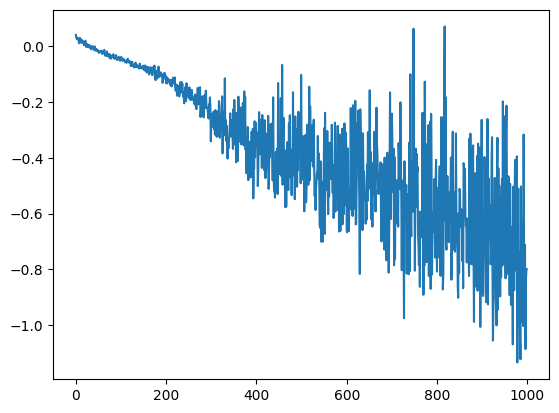

In [15]:
plt.plot(loss_history)
plt.show()

In [16]:
from hflow.data.ode import odeint_rk4

t_int = np.squeeze(t_train[::10])
y0 = sols[0]
def fn(t, y):
    f = np.squeeze(s_dx_Vx(t.reshape(1), y, opt_params))
    return f
    
int_sol = odeint_rk4(fn, y0, t_int)
     

In [17]:
ss = 10
all_sol = jnp.hstack([int_sol, sols[::10]])
L = int_sol[ :, ::ss].shape[1]
cs = [*['r']*L,*['b']*L]

In [18]:
scatter_movie(all_sol[:, ::ss], t=t_int, c=cs, alpha=0.3)